In [2]:
import copy
import pickle
import networkx as nx

# Your own modules ────────────────────────────────────────────────
from dgd.environments.drl3env_loader4 import DRL3env
import dgd.environments.drl3env_loader4 

from dgd.utils.utils5 import (
    energy_score,
    check_implicit_OR_existence_v3,
)

MOTIFS_PATH = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/action_motifs.pkl"
with open(MOTIFS_PATH, "rb") as f:
    action_motifs = pickle.load(f)

UNIQUE_GRAPHS = action_motifs["graphs"]         
TTABLE_TO_ACTIONS = action_motifs["lookup"]
NUM_ACTIONS = len(UNIQUE_GRAPHS)

print(f"Imported DRL3env with {NUM_ACTIONS} rewrite motifs available.")


Done loading action motifs. There are 15928 unique motifs.
Imported DRL3env with 15928 rewrite motifs available.


In [3]:
def load_graph_pickle(filename):
    """
    Load a graph from a pickle file and convert back to NetworkX format.
    
    Args:
        filename (str): Pickle file to load
        
    Returns:
        nx.DiGraph: Reconstructed graph
    """
    # Load the list from pickle
    with open(filename, 'rb') as f:
        graph_list = pickle.load(f)
    
    # Extract components
    num_nodes, edges, node_attrs = graph_list
    
    # Create new graph
    G = nx.DiGraph()
    
    # Add nodes with attributes
    for node, attr in node_attrs.items():
        if attr is not None:
            G.add_node(node, type=attr)
        else:
            G.add_node(node)
    
    # Add edges
    G.add_edges_from(edges)
    
    return G

In [4]:
HEX_ID = "0x0FD5"

# If your pickle lives somewhere else, just point UNOPT_PKL_PATH there
UNOPT_PKL_PATH = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/NIGs_4_inputs/{HEX_ID}_NIG_unoptimized.pkl"

G_seed = load_graph_pickle(UNOPT_PKL_PATH)

e0, _ = energy_score(G_seed, check_implicit_OR_existence_v3)
print(f"Seed-graph energy for {HEX_ID}: {e0:.2f}")


Seed-graph energy for 0x0FD5: 60.00


In [5]:
env = DRL3env(
    max_nodes=len(G_seed) + 100,  
    graphs=[G_seed],             
    max_steps=1,                 
    log_info=False,
)
obs, _ = env.reset(seed=0)

Testing without mask

In [ ]:
'''
from tqdm.auto import tqdm             # auto-selects notebook/terminal renderer

TARGET_ENERGY = 5
hits          = []

for a in tqdm(range(NUM_ACTIONS), desc="Rewrites tested"):
    env_try = copy.deepcopy(env)
    _, _, _, _, _ = env_try.step(a)          # apply one rewrite

    e_new, _ = energy_score(
        env_try.current_solution,
        check_implicit_OR_existence_v3
    )

    tqdm.write(f"Action {a:>3}: energy = {e_new:.2f}")

    if e_new == TARGET_ENERGY:
        hits.append(a)

# ───────────────────────── summary ───────────────────────────────
if hits:
    print(f"\nSUCCESS energy {TARGET_ENERGY} reached with actions: {hits}")
else:
    print(f"\nNo single rewrite hits energy {TARGET_ENERGY}.")
'''

Testing with actions mask

In [6]:

import numpy as np
from tqdm.auto import tqdm

TARGET_ENERGY = 5
hits          = []

# Compute the mask once; index NUM_ACTIONS is the "Terminate" action.
mask = env.action_masks()              # shape: (NUM_ACTIONS + 1,)
valid_actions = np.where(mask[:-1])[0] # drop the terminate 

print(f"{len(valid_actions)} of {NUM_ACTIONS} rewrites are valid for this graph.")

# Exhaustive sweep over valid IDs
for a in tqdm(valid_actions, desc="Valid rewrites tested"):
    env_try = copy.deepcopy(env)
    _, _, _, _, _ = env_try.step(a)          # apply one rewrite

    e_new, _ = energy_score(
        env_try.current_solution,
        check_implicit_OR_existence_v3
    )

    # preserves the progress bar while logging each energy
    tqdm.write(f"Action {a:>3}: energy = {e_new:.2f}")

    if e_new == TARGET_ENERGY:
        hits.append(a)

if hits:
    print(f"\nSUCCESS energy {TARGET_ENERGY} reached with actions: {hits}")
else:
    print(f"\nNo single valid rewrite hits energy {TARGET_ENERGY}.")


423 of 15928 rewrites are valid for this graph.


Valid rewrites tested:   0%|          | 0/423 [00:00<?, ?it/s]

Action   0: energy = 60.00
Action   6: energy = 62.00
Action   7: energy = 62.00
Action   9: energy = 62.00
Action  10: energy = 62.00
Action  11: energy = 57.00
Action  12: energy = 62.00
Action  13: energy = 62.00
Action  14: energy = 60.00
Action  15: energy = 60.00
Action  16: energy = 60.00
Action  17: energy = 61.00
Action  18: energy = 62.00
Action  19: energy = 62.00
Action  20: energy = 60.00
Action  21: energy = 62.00
Action  22: energy = 62.00
Action  23: energy = 57.00
Action  24: energy = 57.00
Action  25: energy = 57.00
Action  26: energy = 57.00
Action  27: energy = 57.00
Action  28: energy = 57.00
Action  29: energy = 60.00
Action  30: energy = 60.00
Action  31: energy = 56.00
Action  32: energy = 61.00
Action  34: energy = 60.00
Action  35: energy = 56.00
Action  37: energy = 62.00
Action  38: energy = 62.00
Action  39: energy = 60.00
Action  40: energy = 62.00
Action  41: energy = 62.00
Action  42: energy = 62.00
Action  43: energy = 60.00
Action  44: energy = 62.00
A

In [7]:

import itertools
import matplotlib.pyplot as plt

if not hits:
    print("Nothing to plot – no rewrite reached the target energy.")
    raise SystemExit

chosen_action = hits[0]          # pick another from `hits` if you wish
print(f"Analysing action ID {chosen_action}")

# ── reconstruct the *final* graph for that action ────────────────
env_final = copy.deepcopy(env)
_, _, _, _, _ = env_final.step(chosen_action)
G_final = env_final.current_solution

# ── retrieve the *rewrite-motif* graph used by that action ───────
G_motif = UNIQUE_GRAPHS[chosen_action]

# ── obtain a canonical form of the final graph (helper fn) ───────
G_final_canon = env_final._canonical_graph_transform(G_final)


Analysing action ID 547


/tmp/ipykernel_316657/2884043502.py:13: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = pydot_layout(g, prog="dot")
/tmp/ipykernel_316657/2884043502.py:13: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = pydot_layout(g, prog="dot")
/tmp/ipykernel_316657/2884043502.py:13: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = pydot_layout(g, prog="dot")


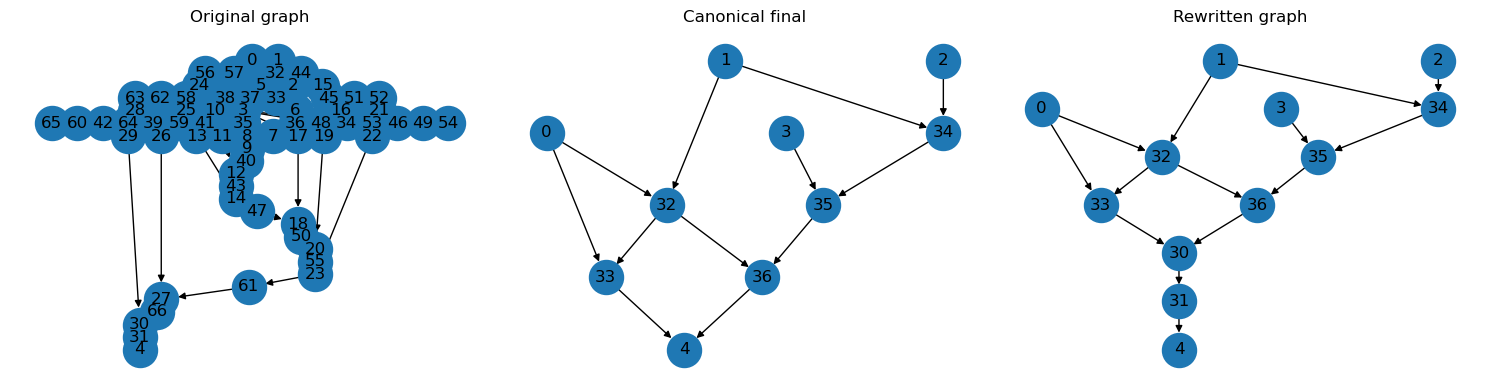

In [8]:
def draw_graph(g, title, ax):
    """
    Draw `g` with a nice hierarchical layout if pygraphviz / pydot are
    available, otherwise fall back to a spring layout.
    """
    #  Try pygraphviz (best look for DAGs)
    try:
        pos = nx.nx_agraph.graphviz_layout(g, prog="dot")
    except (ImportError, AttributeError):
        # Try pydot’s Graphviz interface
        try:
            from networkx.drawing.nx_pydot import graphviz_layout as pydot_layout
            pos = pydot_layout(g, prog="dot")
        except (ImportError, AttributeError):
            # Fallback: spring layout
            pos = nx.spring_layout(g, seed=42)

    nx.draw(
        g, pos,
        with_labels=True,
        arrows=True,
        node_size=600,
        ax=ax
    )
    ax.set_title(title)
    ax.axis("off")


fig, axs = plt.subplots(1, 3, figsize=(15, 4))

draw_graph(G_seed,        "Original graph",  axs[0])
draw_graph(G_final_canon, "Canonical final", axs[1])
draw_graph(G_final,       "Rewritten graph", axs[2])

plt.tight_layout()
plt.show()


/tmp/ipykernel_316657/2884043502.py:13: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = pydot_layout(g, prog="dot")


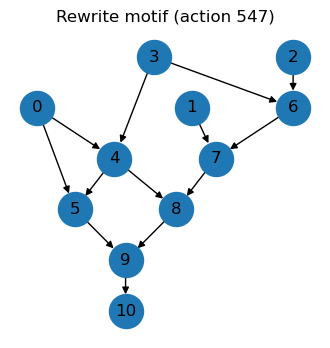

In [9]:
plt.figure(figsize=(4,4))
draw_graph(G_motif, f"Rewrite motif (action {chosen_action})", plt.gca())
plt.show()


In [10]:
for node in G_motif.nodes:
    print(f"Node: {node}")
    for attribute, value in G_motif.nodes[node].items():
        print(f"  {attribute}: {value}")

Node: 0
  type: input
Node: 1
  type: input
Node: 2
  type: input
Node: 3
  type: input
Node: 4
Node: 5
Node: 6
Node: 7
Node: 8
Node: 9
Node: 10
  type: output


In [11]:
e_motif, _ = energy_score(
    G_motif,
    check_implicit_OR_existence_v3
)
e_motif

6

/tmp/ipykernel_316657/1882437967.py:29: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = pydot_layout(G, prog="dot")
/tmp/ipykernel_316657/1882437967.py:29: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = pydot_layout(G, prog="dot")
/tmp/ipykernel_316657/1882437967.py:29: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = pydot_layout(G, prog="dot")
/tmp/ipykernel_316657/1882437967.py:39: MatplotlibDeprecat

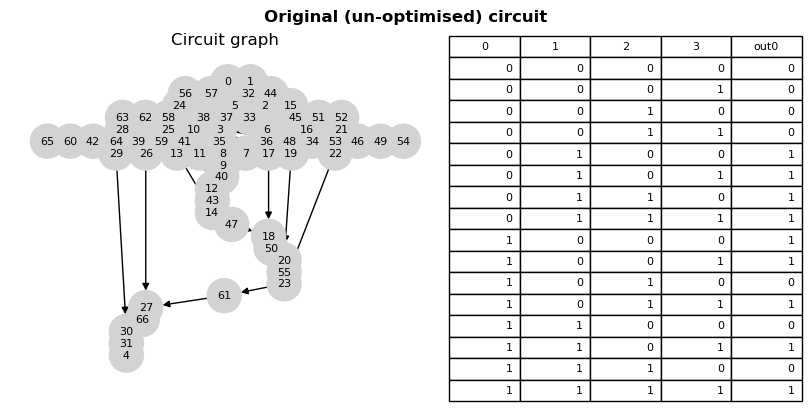

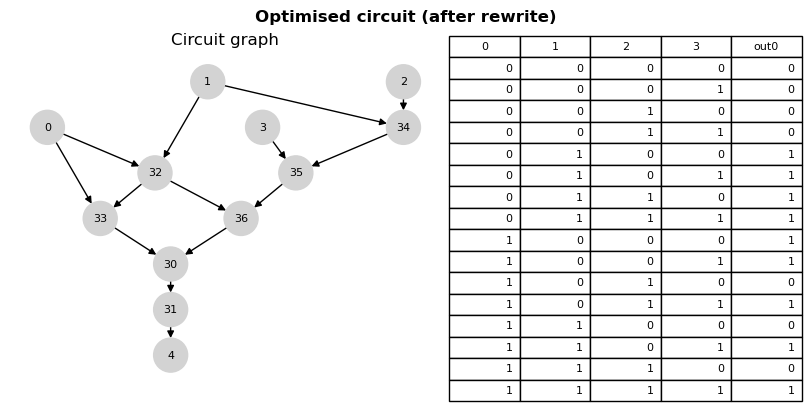

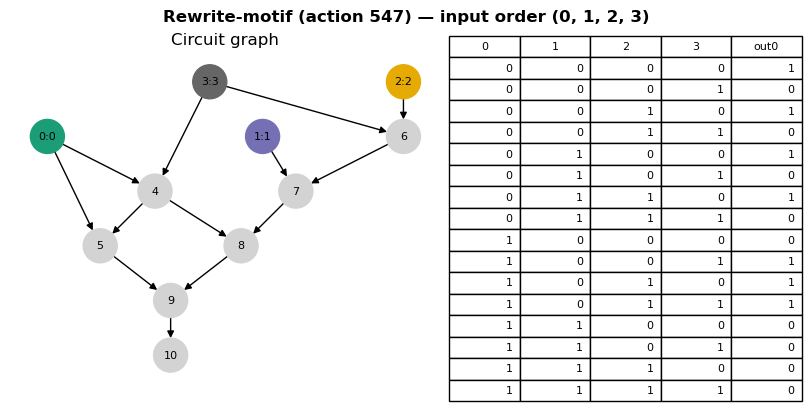

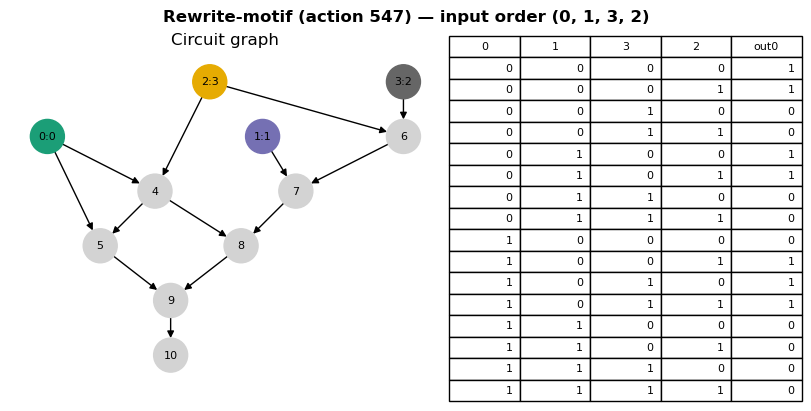

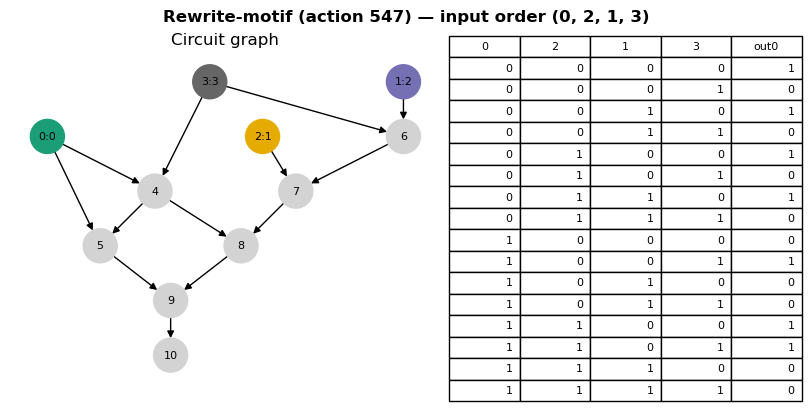

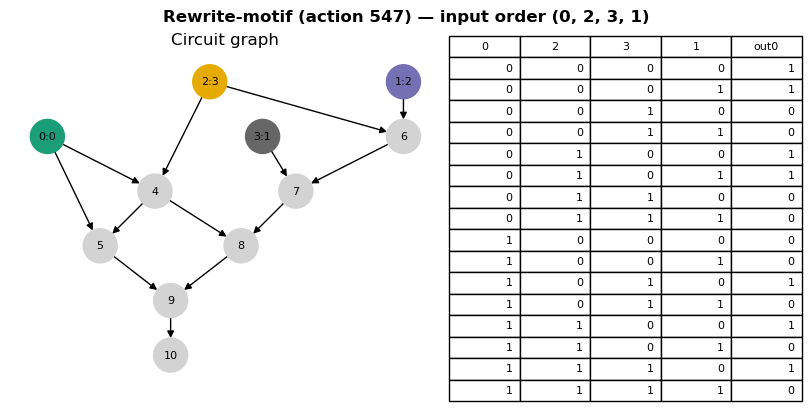

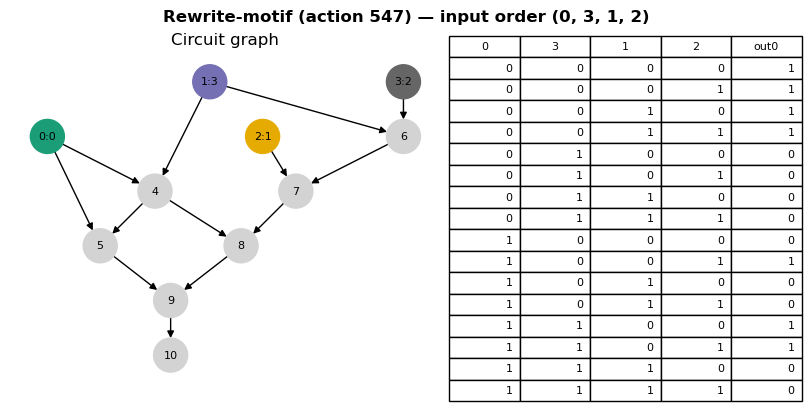

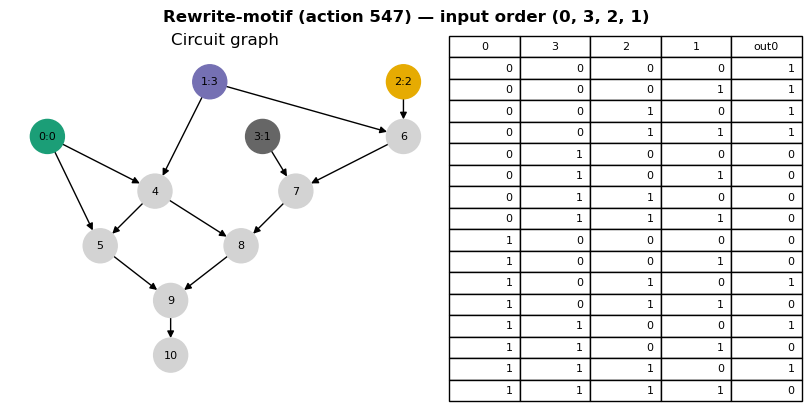

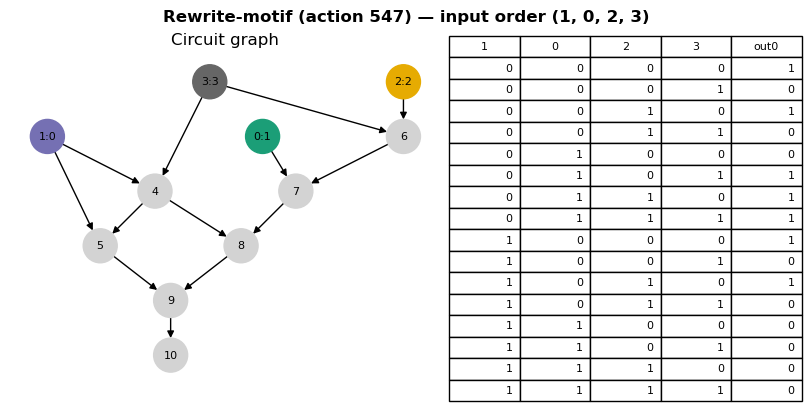

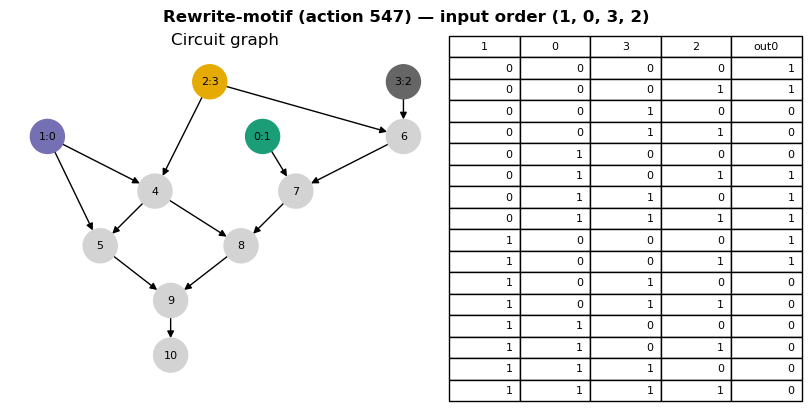

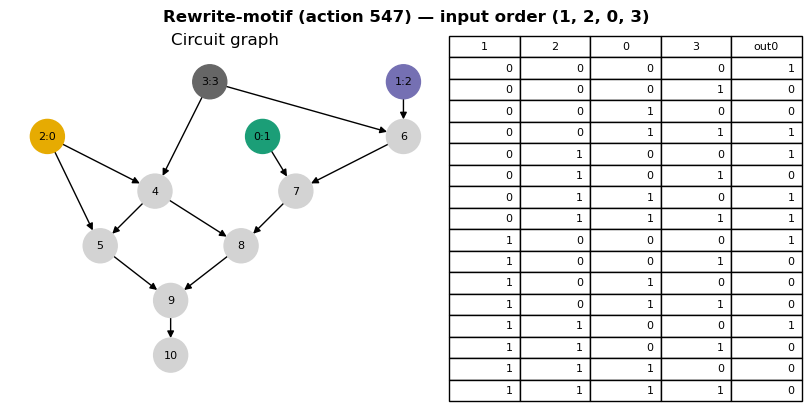

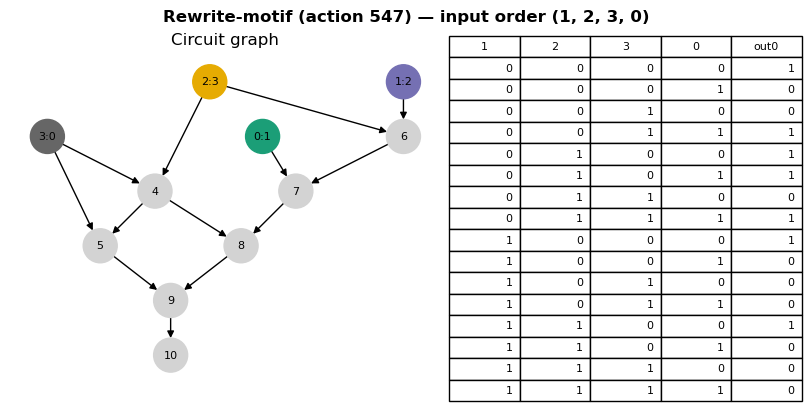

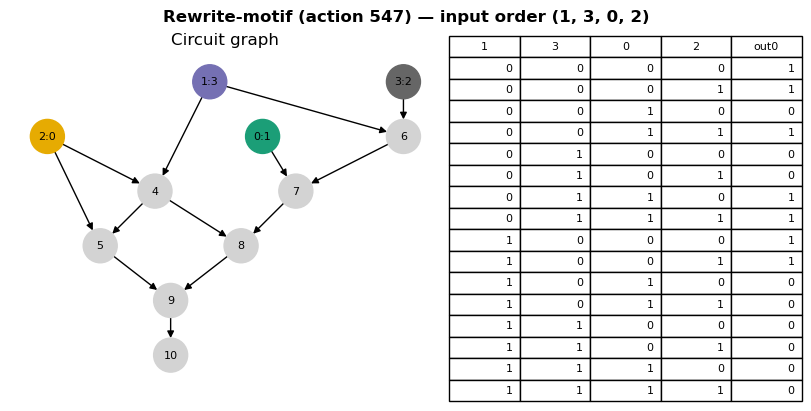

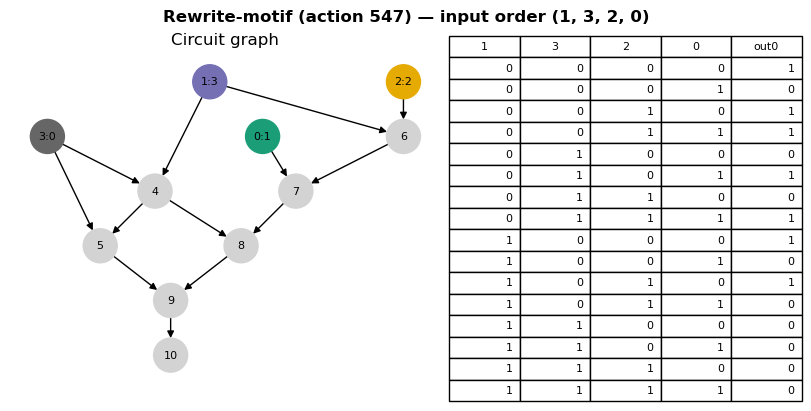

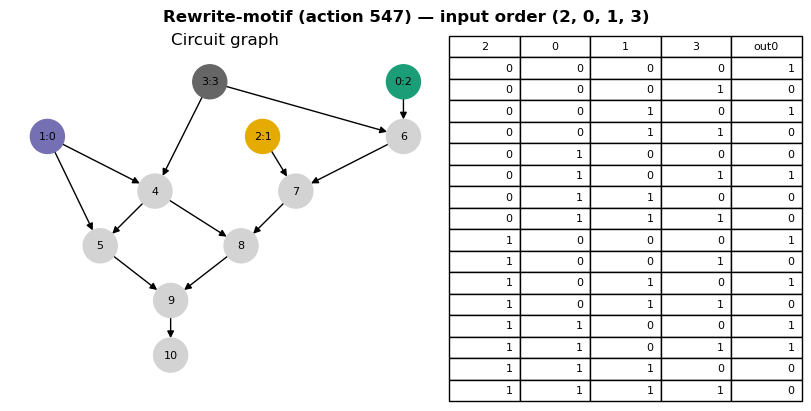

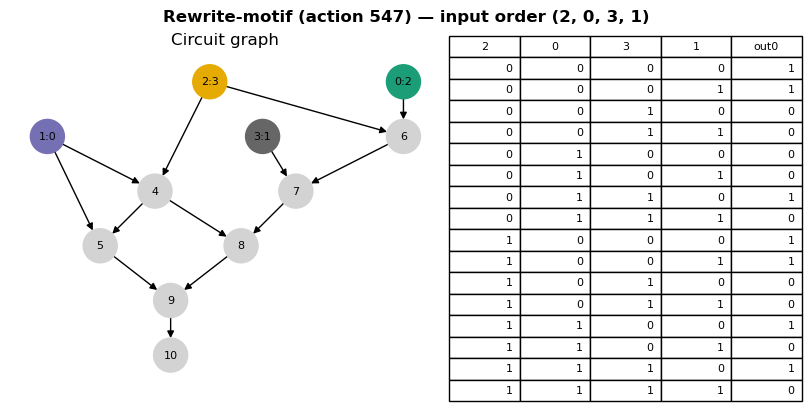

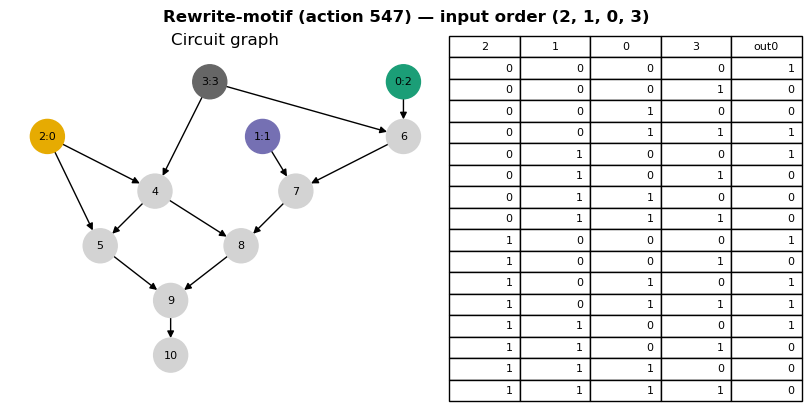

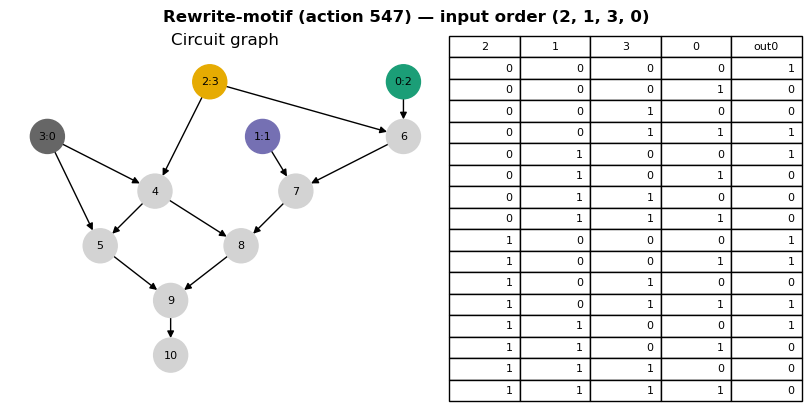

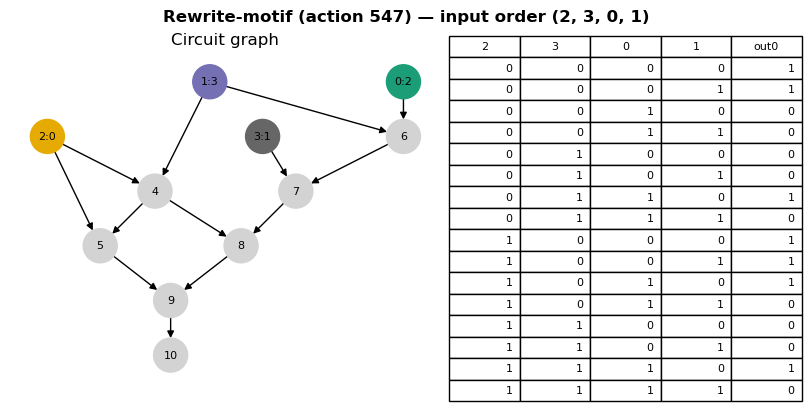

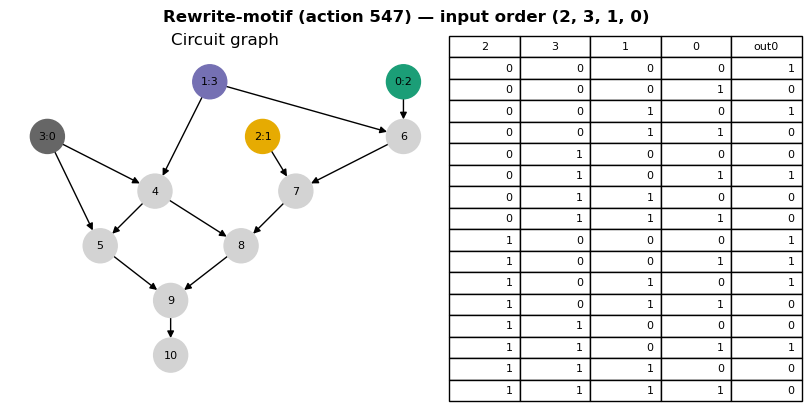

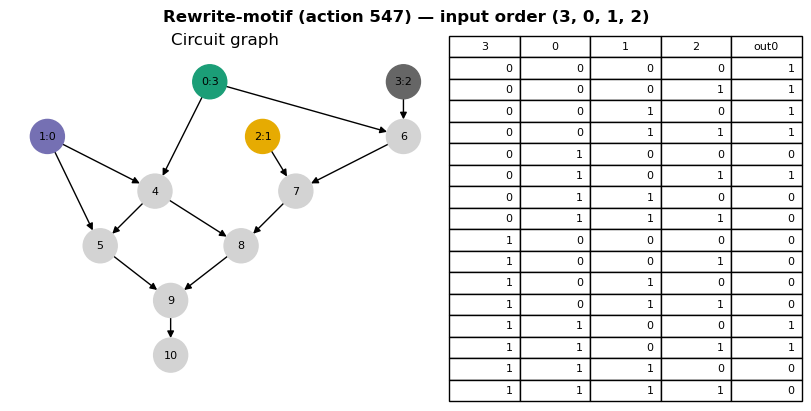

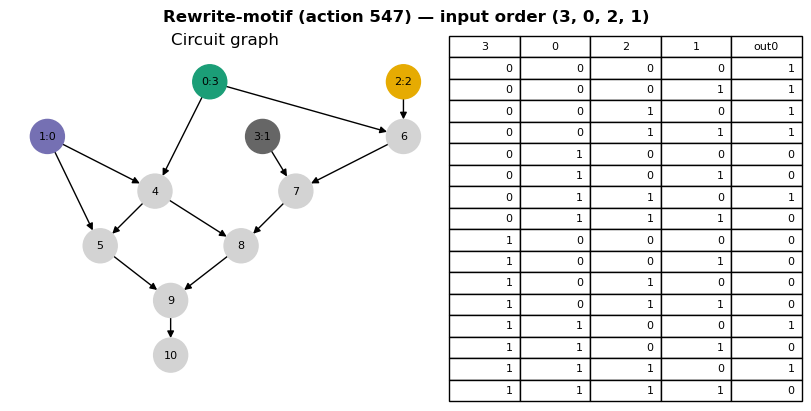

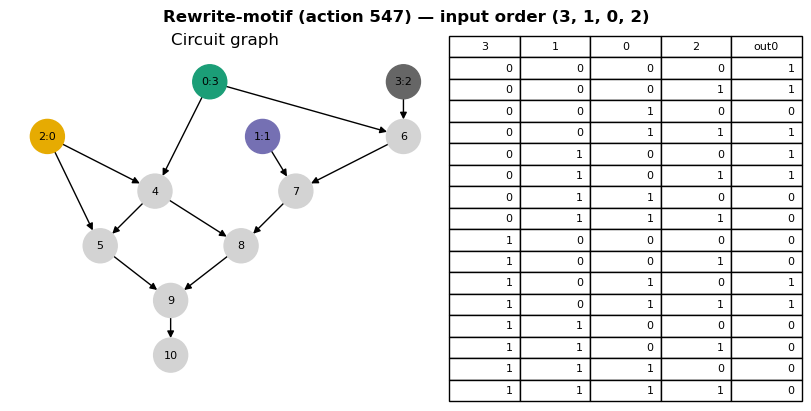

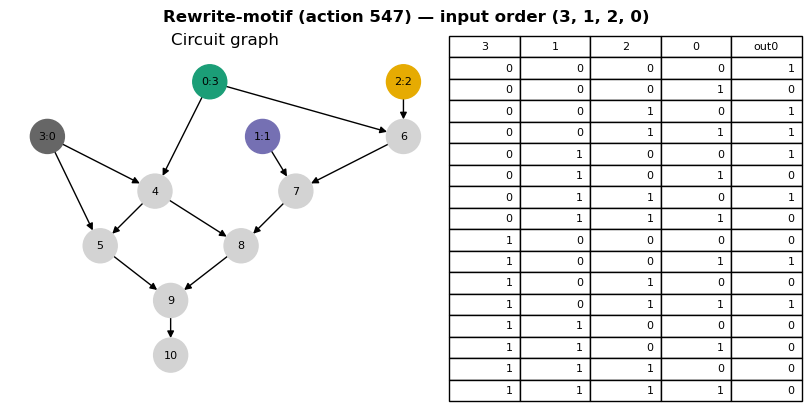

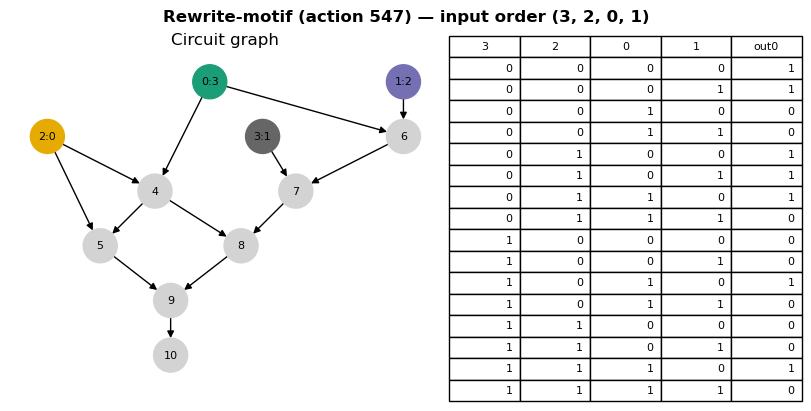

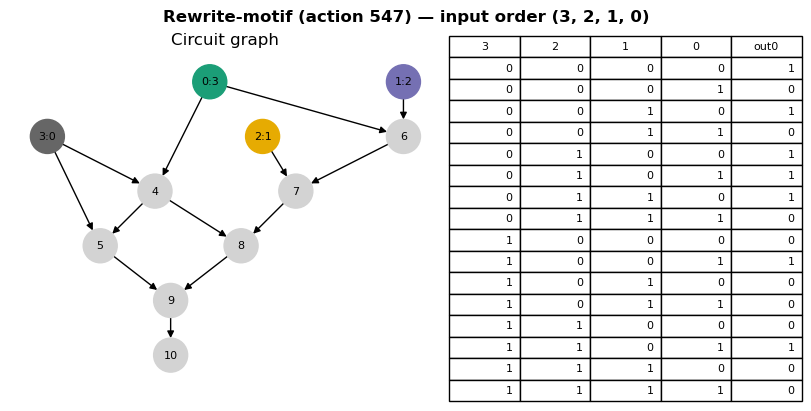

In [17]:
import itertools
import copy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx

from dgd.utils.utils5 import calculate_truth_table_v2


# ──────────────────────────────────────────────────────────────────────────────
# 0.  Graph-drawing helper   ← UPDATED
# ──────────────────────────────────────────────────────────────────────────────
def draw_graph(g, title, ax, input_order=None):
    """
    Draw `g` with a nice hierarchical layout if Graphviz is available.
    If `input_order` is supplied, colour those nodes and prefix their labels
    with the permutation index (0:, 1:, …) so permutations are visible.
    """
    # Work on a copy so we don’t mutate the caller’s graph
    G = copy.deepcopy(g)

    # 1️⃣ Layout ─ graphviz "dot" → pydot → spring fallback
    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
    except (ImportError, AttributeError):
        try:
            from networkx.drawing.nx_pydot import graphviz_layout as pydot_layout
            pos = pydot_layout(G, prog="dot")
        except (ImportError, AttributeError):
            pos = nx.spring_layout(G, seed=42)

    # 2️⃣ Node colours & labels
    default_colour = "lightgray"
    node_colors = [default_colour] * G.number_of_nodes()
    labels = {n: str(n) for n in G.nodes()}

    if input_order is not None:
        cmap = cm.get_cmap("Dark2", len(input_order))
        for idx, node in enumerate(input_order):
            # Colour
            try:
                node_idx = list(G.nodes()).index(node)
                node_colors[node_idx] = cmap(idx)
            except ValueError:
                pass  # just in case the permutation contains an invalid node
            # Prefix label with order index
            labels[node] = f"{idx}:{labels[node]}"

    # 3️⃣ Draw
    nx.draw(
        G, pos,
        with_labels=False,        # we’ll add labels separately
        arrows=True,
        node_size=600,
        node_color=node_colors,
        ax=ax
    )
    nx.draw_networkx_labels(G, pos, labels=labels, ax=ax, font_size=8)
    ax.set_title(title)
    ax.axis("off")


# ──────────────────────────────────────────────────────────────────────────────
# 1.  Truth-table helper (unchanged)
# ──────────────────────────────────────────────────────────────────────────────
def truth_table_df(G, input_order=None):
    input_nodes  = [n for n in G if G.in_degree(n)  == 0]
    output_nodes = [n for n in G if G.out_degree(n) == 0]

    if input_order is None:
        input_order = input_nodes
    else:
        assert set(input_order) == set(input_nodes), \
            "input_order must be a permutation of the graph’s input nodes"

    perm_indices = [input_nodes.index(n) for n in input_order]
    tt = calculate_truth_table_v2(G)

    rows = []
    for in_bits_disp in itertools.product([0, 1], repeat=len(input_nodes)):
        in_bits_lookup = [None] * len(input_nodes)
        for pos, idx in enumerate(perm_indices):
            in_bits_lookup[idx] = in_bits_disp[pos]
        in_bits_lookup = tuple(in_bits_lookup)
        out_bits = tt[in_bits_lookup]
        rows.append(list(in_bits_disp) + list(out_bits))

    columns = list(map(str, input_order)) + [f"out{j}" for j in range(len(output_nodes))]
    return pd.DataFrame(rows, columns=columns)


# ──────────────────────────────────────────────────────────────────────────────
# 2.  Plot graph + truth table   ← UPDATED (just passes input_order through)
# ──────────────────────────────────────────────────────────────────────────────
def plot_graph_with_tt(G, *, input_order=None, title="", figsize=(8, 4),
                       graph_ax_width=0.55):
    df = truth_table_df(G, input_order=input_order)

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs  = fig.add_gridspec(1, 2, width_ratios=[graph_ax_width, 1 - graph_ax_width])

    # 2.1 Graph panel
    ax_graph = fig.add_subplot(gs[0, 0])
    draw_graph(G, "Circuit graph", ax_graph, input_order=input_order)

    # 2.2 Truth-table panel
    ax_tt = fig.add_subplot(gs[0, 1])
    ax_tt.axis("off")
    tbl = ax_tt.table(cellText=df.values,
                      colLabels=df.columns,
                      loc="center")
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(8)
    tbl.scale(1, 1.2)

    if title:
        fig.suptitle(title, fontweight="bold")

    return fig


# ──────────────────────────────────────────────────────────────────────────────
# 3.  Example usage
# ──────────────────────────────────────────────────────────────────────────────
# (a) Seed and final circuits
plot_graph_with_tt(G_seed,  title="Original (un-optimised) circuit")
plot_graph_with_tt(G_final, title="Optimised circuit (after rewrite)")

# (b) All permutations for the motif
motif_inputs = [n for n in G_motif if G_motif.in_degree(n) == 0]
for perm in itertools.permutations(motif_inputs):
    ttl = f"Rewrite-motif (action {chosen_action}) — input order {perm}"
    plot_graph_with_tt(G_motif, input_order=list(perm), title=ttl)

plt.show()      # one call at the end


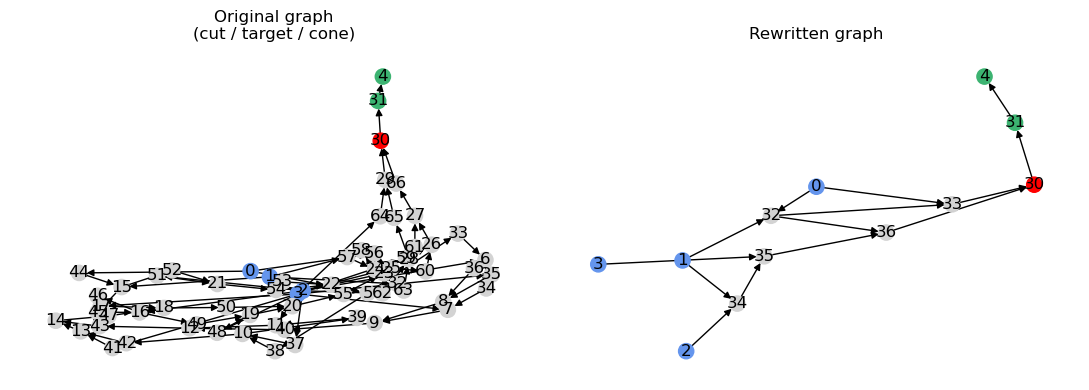

In [19]:
import matplotlib.pyplot as plt
import networkx as nx
import copy

env_viz   = copy.deepcopy(env)
G_before  = env_viz.current_solution.copy()

# Populate the action-mask cache -> env_viz._subgraphs_for_action[…]
env_viz.action_masks()

# Every entry is (target, cut_tuple, tt_key); pick the candidate that
# was actually used once we perform `step(chosen_action)`.
candidates = env_viz._subgraphs_for_action[chosen_action]


# Execute the chosen action once to get the rewritten graph
env_viz.step(chosen_action)
G_after = env_viz.current_solution

# Nodes that disappeared are in the cut; use that to locate
# which candidate the env picked (there’s usually exactly one).
removed_nodes = set(G_before.nodes) - set(G_after.nodes)

target_node, cut_nodes = None, None
for tgt, cut_tup, _ in candidates:
    if set(cut_tup) == removed_nodes:
        target_node, cut_nodes = tgt, set(cut_tup)
        break

# Fallback if env picked a variant with additional renaming, etc.
if target_node is None:
    # best-effort: first candidate
    target_node, cut_nodes, _ = candidates[0]
    cut_nodes = set(cut_nodes)

# The cone = all descendants of target in the after graph
cone_nodes = nx.descendants(G_after, target_node) if target_node in G_after else set()

def colour_map(G):
    cmap = {}
    for n in G:
        if n == target_node:
            cmap[n] = "red"                 # target
        elif n in cut_nodes:
            cmap[n] = "cornflowerblue"      # cut
        elif n in cone_nodes:
            cmap[n] = "mediumseagreen"      # cone
        else:
            cmap[n] = "lightgrey"
    return cmap

def draw(G, title, ax, cmap):
    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G, pos,
        node_color=[cmap[n] for n in G],
        with_labels=True,
        arrows=True,
        node_size=120,
        ax=ax,
    )
    ax.set_title(title)
    ax.axis("off")

fig, ax = plt.subplots(1, 2, figsize=(11, 4))

draw(G_before, "Original graph\n(cut / target / cone)", ax[0], colour_map(G_before))
draw(G_after,  "Rewritten graph",                        ax[1], colour_map(G_after))

plt.tight_layout()
plt.show()
